In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets sentencepiece

In [ ]:
import torch
import numpy as np
import pandas as pd



print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

In [8]:
!pip install -q pytesseract seqeval

In [2]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("jinhybr/WildReceipt")

/Users/taojin/Projects/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting data files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]
Generating train split: 0 examples [00:00, ? examples/s]/Users/taojin/Projects/env/lib/python3.8/site-packages/datasets/download/streaming_download_manager.py:714: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)
Generating test split: 0 examples [00:00, ? examples/s]          /Users/taojin/Projects/env/lib/python3.8/site-packages/datasets/download/streaming_download_manager.py:714: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support rege

Dataset wild_receipt downloaded and prepared to /Users/taojin/.cache/huggingface/datasets/jinhybr___wild_receipt/WildReceipt/1.0.0/d6bb137b7a99f72b8489749d6511bb4af603c0ab89d00ab36d3c8a55e74d3f40. Subsequent calls will reuse this data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 508.40it/s]


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 1267
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 472
    })
})

In [4]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['Ignore', 'Store_name_value', 'Store_name_key', 'Store_addr_value', 'Store_addr_key', 'Tel_value', 'Tel_key', 'Date_value', 'Date_key', 'Time_value', 'Time_key', 'Prod_item_value', 'Prod_item_key', 'Prod_quantity_value', 'Prod_quantity_key', 'Prod_price_value', 'Prod_price_key', 'Subtotal_value', 'Subtotal_key', 'Tax_value', 'Tax_key', 'Tips_value', 'Tips_key', 'Total_value', 'Total_key', 'Others'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None)}

In [16]:
example = dataset["train"][0]
example["image_path"]

'/Users/taojin/.cache/huggingface/datasets/downloads/extracted/15002aaf1a38827fb1b3ce2ebf1047ce6c426103eea021f8077af83209f889f5/wildreceipt/image_files/Image_16/11/d5de7f2a20751e50b84c747c17a24cd98bed3554.jpeg'

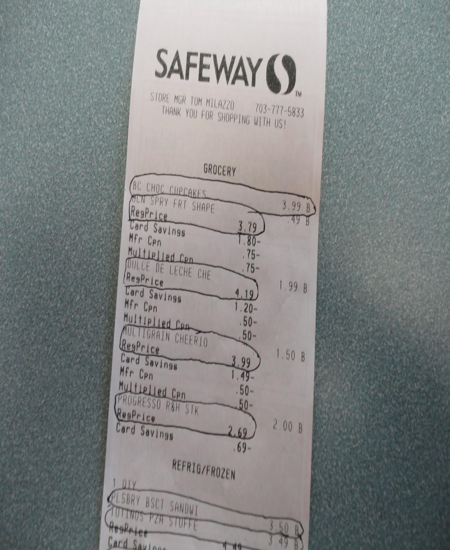

In [17]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(example["image_path"])
image = image.convert("RGB")
#image.resize((350,450))
image.resize((450,550))

In [7]:
words, bboxes, ner_tags = example["words"], example["bboxes"], example["ner_tags"]
print(words)
print(bboxes)
print(ner_tags)

['SAFEWAY', 'TM', 'ATOREMGRTOMMILAZZO', '703-777-5833', 'THANKYOUFORSHOPPINGWITHUS!', 'GROCERY', 'BCCHOCCUPCAKES', 'ACNSPRYFRTSHAPE', 'Regprice', 'Cardsavings', 'MfrCpn', 'MultipliedCpn', 'DULCEDELECHECHE', 'Regprice', 'CardSavings', 'MfrCpn', 'MuitipliedCpn', 'MULTIGRAINCHEERIO', 'RegPrice', 'CardSavings', 'MfrCpn', 'MuitieliedCpn', 'PROGRESSOR&HSTK', 'RegPrice', 'CardSavings', 'REFRIG/FROZEN', '3.99', '.49', '3.79', '1.80-', '.75-', '.75-', '1.99', '4.19', '1.20-', '.50-', '.50-', '1.50', '3.99', '1.49-', '.50-', '.50-', '2.00', '2.69', '.69-', '1OIY', 'PLSBRYBSCTSANDWI', 'TOTINOSPZASTOFFE', 'RegPrice', '', '', '3.50', '3.49', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
[[343, 86, 585, 158], [655, 163, 671, 175], [334, 166, 520, 199], [566, 185, 675, 213], [360, 191, 635, 235], [452, 295, 525, 322], [296, 328, 458, 360], [293, 350, 477, 388], [291, 373, 371, 402], [289, 398, 411, 430], [286, 422, 358, 448], [284, 446, 428, 481], [283, 470, 468, 509], [280, 494, 363, 520], [278, 519, 402, 551]

In [9]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

The size parameter should be a dictionary with keys ('height', 'width'), ('shortest_edge', 'longest_edge') or ('shortest_edge',) got 224. Setting as {'height': 224, 'width': 224}.


In [25]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image_path"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [26]:
print(label_list)

['Ignore', 'Store_name_value', 'Store_name_key', 'Store_addr_value', 'Store_addr_key', 'Tel_value', 'Tel_key', 'Date_value', 'Date_key', 'Time_value', 'Time_key', 'Prod_item_value', 'Prod_item_key', 'Prod_quantity_value', 'Prod_quantity_key', 'Prod_price_value', 'Prod_price_key', 'Subtotal_value', 'Subtotal_key', 'Tax_value', 'Tax_key', 'Tips_value', 'Tips_key', 'Total_value', 'Total_key', 'Others']


In [27]:
print(id2label)

{0: 'Ignore', 1: 'Store_name_value', 2: 'Store_name_key', 3: 'Store_addr_value', 4: 'Store_addr_key', 5: 'Tel_value', 6: 'Tel_key', 7: 'Date_value', 8: 'Date_key', 9: 'Time_value', 10: 'Time_key', 11: 'Prod_item_value', 12: 'Prod_item_key', 13: 'Prod_quantity_value', 14: 'Prod_quantity_key', 15: 'Prod_price_value', 16: 'Prod_price_key', 17: 'Subtotal_value', 18: 'Subtotal_key', 19: 'Tax_value', 20: 'Tax_key', 21: 'Tips_value', 22: 'Tips_key', 23: 'Total_value', 24: 'Total_key', 25: 'Others'}


In [28]:
'''def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding'''


def prepare_examples(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']] #Image.open(examples[image_column_name])
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [29]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

  0%|                                                                                                                                                                                                              | 0/1 [00:07<?, ?ba/s]


In [30]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> SAFEWAY TM ATOREMGRTOMMILAZZO 703-777-5833 THANKYOUFORSHOPPINGWITHUS! GROCERY BCCHOCCUPCAKES ACNSPRYFRTSHAPE Regprice Cardsavings MfrCpn MultipliedCpn DULCEDELECHECHE Regprice CardSavings MfrCpn MuitipliedCpn MULTIGRAINCHEERIO RegPrice CardSavings MfrCpn MuitieliedCpn PROGRESSOR&HSTK RegPrice CardSavings REFRIG/FROZEN 3.99.49 3.79 1.80-.75-.75- 1.99 4.19 1.20-.50-.50- 1.50 3.99 1.49-.50-.50- 2.00 2.69.69- 1OIY PLSBRYBSCTSANDWI TOTINOSPZASTOFFE RegPrice 3.50 3.49 B B B B B B B</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [31]:
train_dataset.set_format("torch")

In [32]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [33]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 472
})

In [34]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> CHOEUN KOREANRESTAURANT 2621ORANGETHORPEAVE,FULLERTON. (714)879-3574 THANKYOU!! DATE 12/30/2016FRI 19:19 BIBIM.OCTOPUT1 S-FOODP.CAKT1 PORKDUMPLINT1 LABEEFRIBT1 $13.99 $14.99 $8.99 ￥17.99 4.00xITEMS SUBTOTAL TAX1 TOTAL $55.96 $4.48 $60.44 TIME</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [35]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 SAF 1
EW -100
AY -100
 TM 25
 AT 25
OR -100
EM -100
GR -100
T -100
OM -100
M -100
IL -100
AZ -100
Z -100
O -100
 7 5
03 -100
- -100
777 -100
- -100
58 -100
33 -100
 THANK 25
YOU -100
FOR -100
SH -100
OP -100
P -100
ING -100
W -100
ITH -100
US -100
! -100
 GR 25
OC -100
ERY -100
 BC 11
CHO -100
CC -100
U -100
PC -100
AK -100
ES -100
 AC 11
N -100
SP -100
RY -100
FR -100
TS -100
H -100
APE -100
 Reg 25
price -100
 Cards 25
av -100
ings -100
 M 25
fr -100
C -100
pn -100
 Multi 25
pl -100
ied -100
C -100
pn -100
 DU 11
LC -100
ED -100
E -100
LE -100
CH -100
EC -100
HE -100
 Reg 25
price -100
 Card 25
Sav -100
ings -100
 M 25
fr -100
C -100
pn -100
 M 25
uit -100
ipl -100
ied -100
C -100
pn -100
 M 11
ULT -100
IG -100
RA -100
IN -100
CH -100
E -100
ER -100
IO -100
 Reg 25
Price -100
 Card 25
Sav -100
ings -100
 M 25
fr -100
C -100
pn -100
 M 25
uit -100
iel -100
ied -100
C -100
pn -100
 PROG 11
R -100
ESS -100
OR -100
& -100
H -100
ST -100
K -100
 Reg 25
Price -100
 Card 25
Sav -1

In [36]:
from datasets import load_metric

metric = load_metric("seqeval")

/var/folders/3x/h9w8_z6d21vfgw8t5v52nmv00000gn/T/ipykernel_18129/3097260500.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [37]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [38]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501M/501M [00:30<00:00, 16.7MB/s]
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
from huggingface_hub import HfFolder

repo_id = 'OCR-LayoutLMv3-Invoice'

In [47]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir=repo_id,
                                  max_steps=6000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  logging_dir=f"{repo_id}/logs",
                                  logging_strategy="steps",
                                  #report_to="tensorboard",
                                  push_to_hub = True,
                                  hub_strategy="every_save",
                                  hub_model_id= repo_id,
                                  hub_token=HfFolder.get_token(),
                                 )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [48]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/taojin/Projects/env/lib/python3.8/site-packages/huggingface_hub/repository.py:705: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  warnings.warn(
Cloning https://huggingface.co/jinhybr/OCR-LayoutLMv3-Invoice into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

max_steps is given, it will override any value given in num_train_epochs


In [49]:
trainer.train()

/Users/taojin/Projects/env/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1267
  Num Epochs = 10
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 6000
  Number of trainable parameters = 125937562
/Users/taojin/Projects/env/lib/python3.8/site-packages/transformers/modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# change apply_ocr to True to use the ocr text for inference
#processor.feature_extractor.apply_ocr = True

# Save processor and create model card
processor.save_pretrained(repo_id)
trainer.create_model_card()
trainer.push_to_hub()